# Hit or Miss: Game Edition

## by <span style="color:blue"> Nam Pham </span>

## Utils

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# Suppress backend logs and Keras verbosity
import os
from tensorflow.keras.utils import disable_interactive_logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
disable_interactive_logging()

## Data Loading

In [3]:
df = pd.read_csv("Video_Games_Sales_as_at_22_Dec_2016.csv")

# Confirmed the dataset met the criteria  
print("Shape of dataset:", df.shape)
df.head()

Shape of dataset: (16719, 16)


,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


## Visualization

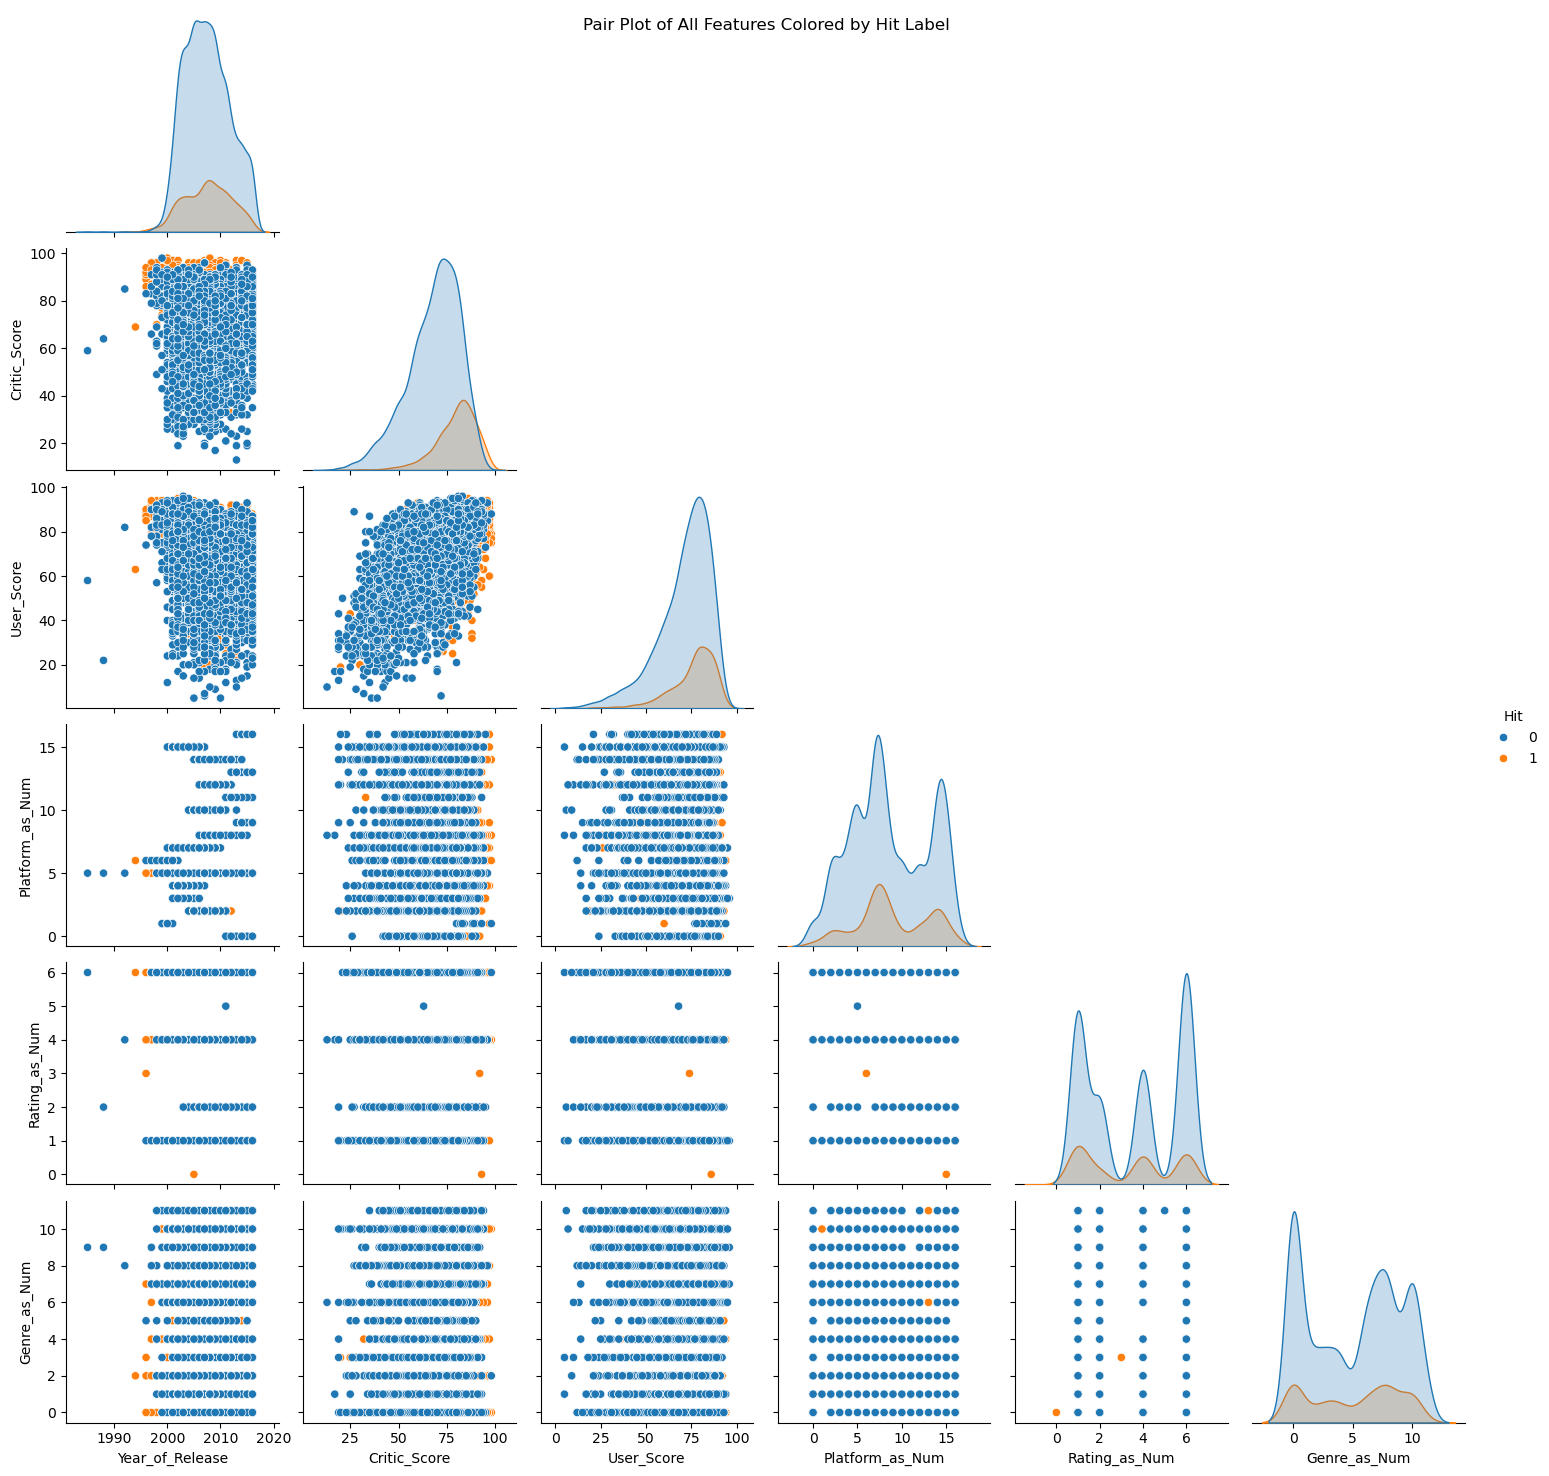

In [4]:
# Drop rows with missing or invalid values needed
cols = ['Platform', 'Year_of_Release', 'Critic_Score', 'User_Score', 'Rating', 'Genre', 'Global_Sales']
df_clean = df.dropna(subset = cols)

df_clean = df_clean[df_clean['User_Score'] != 'tbd']
df_clean['User_Score'] = df_clean['User_Score'].astype(float) * 10
df_clean['Hit'] = (df_clean['Global_Sales'] >= 1.0).astype(int)

# Drop unused columns
drop_cols = ['Name', 'Publisher', 'Developer', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales', 'Critic_Count', 'User_Count']
df_clean.drop(columns = drop_cols, inplace = True, errors = 'ignore')

# Temporary numeric encoding of categorical features for visualization
for col in ['Platform', 'Rating', 'Genre']:
    df_clean[col + '_as_Num'] = df_clean[col].astype('category').cat.codes

pp_cols = ['Year_of_Release', 'Critic_Score', 'User_Score', 'Platform_as_Num', 'Rating_as_Num', 'Genre_as_Num', 'Hit']
sns.pairplot(
    df_clean[pp_cols],
    hue = 'Hit',
    corner = True # To avoid mirrored plots
)
plt.suptitle("Pair Plot of All Features Colored by Hit Label")
plt.show()

# Drop temporary numeric encodings after pairplot
for col in ['Platform_as_Num', 'Rating_as_Num', 'Genre_as_Num']:
    df_clean.drop(columns = col, inplace = True)

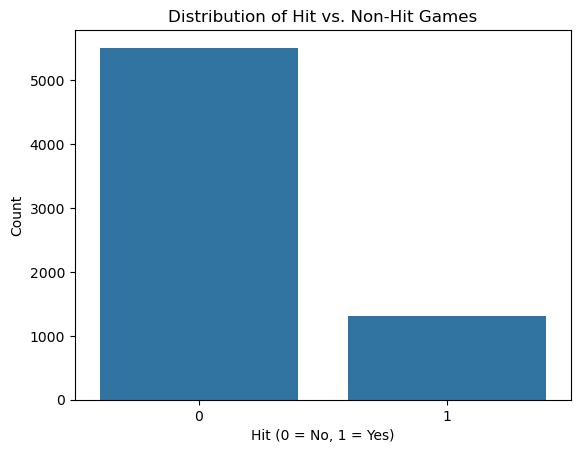

In [5]:
sns.countplot(data = df_clean, x = 'Hit')
plt.title("Distribution of Hit vs. Non-Hit Games")
plt.xlabel("Hit (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()

## Data Preprocessing

### Data Splitting

In [6]:
X = df_clean.drop(columns = 'Hit')
y = df_clean['Hit']

# Split data: 64% train, 16% validation, 20% test
# stratify ensures each split maintains the same proportion of hit vs. non-hit games
X_trn_df, X_tst_df, y_trn, y_tst = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)
X_trn_df, X_vld_df, y_trn, y_vld = train_test_split(X_trn_df, y_trn, test_size = 0.2, random_state = 42, stratify = y_trn)

# Checks
# print("Training set:", X_trn_df.shape)
# print("Validation set:", X_vld_df.shape)
# print("Test set:", X_tst_df.shape)

### Numeric Encoding and Feature Scaling 

In [7]:
cat_features = ['Platform', 'Rating', 'Genre']
num_features = ['Year_of_Release', 'Critic_Score', 'User_Score']

encoder = OneHotEncoder(handle_unknown = 'ignore')
scaler = StandardScaler()

preprocessor = ColumnTransformer(
    transformers = [
        ('cat', encoder, cat_features),
        ('num', scaler, num_features)
    ]
)

X_trn = preprocessor.fit_transform(X_trn_df)
X_vld = preprocessor.transform(X_vld_df)
X_tst = preprocessor.transform(X_tst_df)

# Checks
print("Training set:", X_trn.shape)
print("Validation set:", X_vld.shape)
print("Test set:", X_tst.shape)

Training set: (4368, 39)
Validation set: (1092, 39)
Test set: (1366, 39)


## Logistic Regression

### Training

Training Accuracy: 0.722985347985348
Recall for Hit (1): 0.7654761904761904


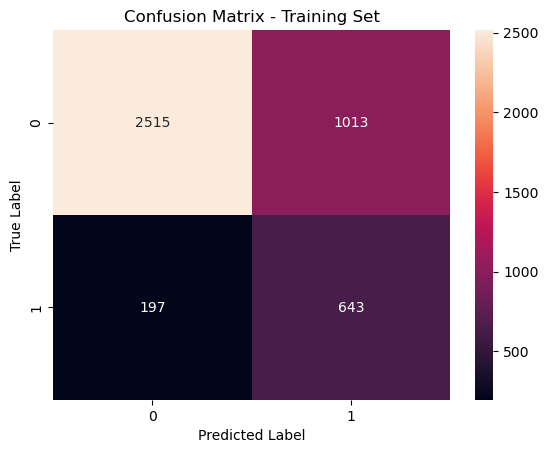

In [8]:
# 'balanced' helps mitigate the imbalance distribution
lr = LogisticRegression(class_weight = 'balanced', max_iter = 1000, random_state = 42)
lr.fit(X_trn, y_trn)
                        
y_trn_hat = lr.predict(X_trn)
print("Training Accuracy:", accuracy_score(y_trn, y_trn_hat))
print("Recall for Hit (1):", recall_score(y_trn, y_trn_hat))

sns.heatmap(confusion_matrix(y_trn, y_trn_hat), annot = True, fmt = 'd')
plt.title("Confusion Matrix - Training Set")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### Validation

Validation Accuracy: 0.6941391941391941
Recall for Hit (1): 0.6857142857142857


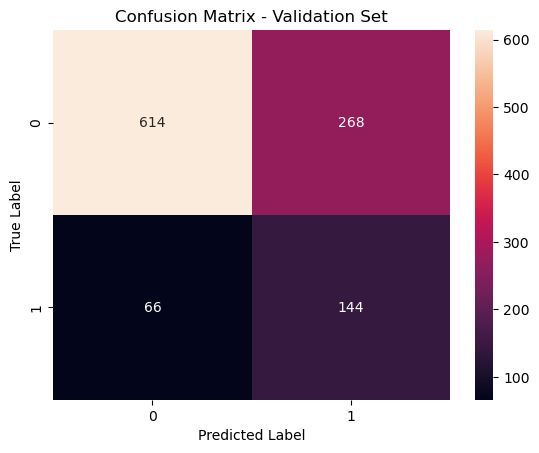

In [9]:
y_vld_hat = lr.predict(X_vld)
print("Validation Accuracy:", accuracy_score(y_vld, y_vld_hat))
print("Recall for Hit (1):", recall_score(y_vld, y_vld_hat))

sns.heatmap(confusion_matrix(y_vld, y_vld_hat), annot = True, fmt = 'd')
plt.title("Confusion Matrix - Validation Set")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### Learning Curve Analysis	

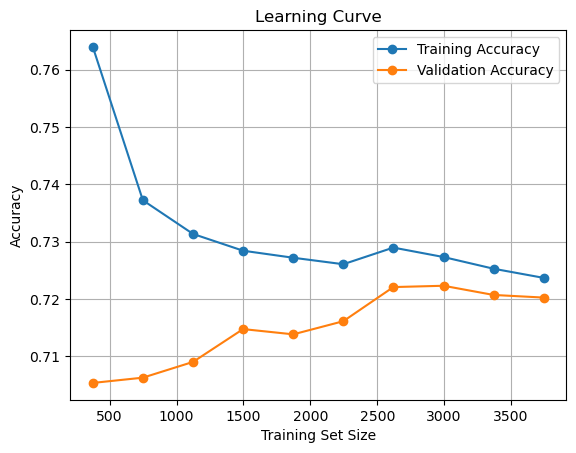

In [10]:
train_sizes, train_scores, vld_scores = learning_curve(
    estimator = LogisticRegression(class_weight = 'balanced', max_iter = 1000, random_state = 42),
    X = X_trn,
    y = y_trn,
    train_sizes = np.linspace(0.1, 1.0, 10),
    cv = 7,
    scoring = 'accuracy',
    shuffle = True,
    random_state = 42
)

train_scores_mean = train_scores.mean(axis = 1)
vld_scores_mean = vld_scores.mean(axis = 1)

plt.plot(train_sizes, train_scores_mean, 'o-', label = 'Training Accuracy')
plt.plot(train_sizes, vld_scores_mean, 'o-', label = 'Validation Accuracy')
plt.title("Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.show()

### Testing

Test Accuracy: 0.7291361639824304
Recall for Hit (1): 0.752851711026616


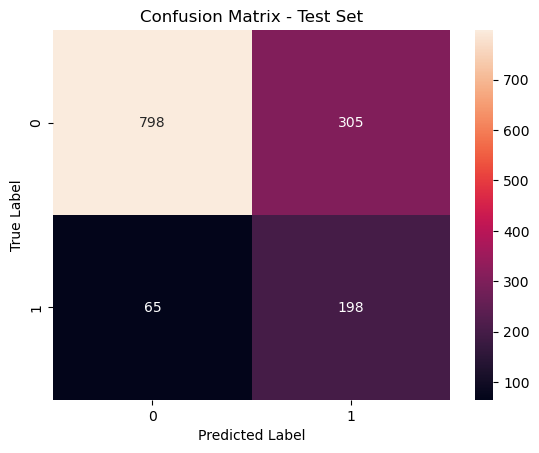

In [11]:
y_tst_hat = lr.predict(X_tst)
print("Test Accuracy:", accuracy_score(y_tst, y_tst_hat))
print("Recall for Hit (1):", recall_score(y_tst, y_tst_hat))

sns.heatmap(confusion_matrix(y_tst, y_tst_hat), annot = True, fmt = 'd')
plt.title("Confusion Matrix - Test Set")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## Neural Network

### Training

Training Accuracy: 0.8466117216117216
Recall for Hit (1): 0.638095238095238


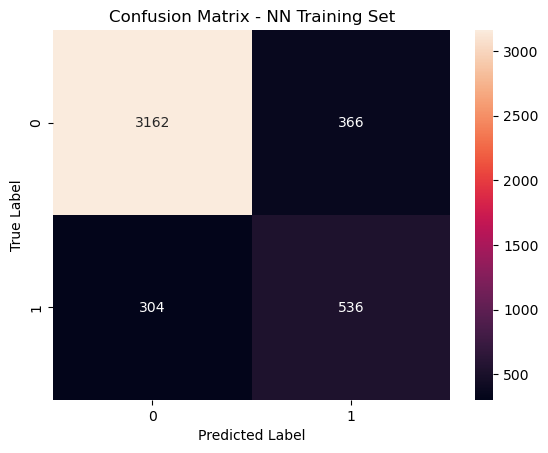

In [12]:
# Network Creation
# Set random seed for reproducibility
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

nn = Sequential([
    Input(shape = (X_trn.shape[1],)),
    Dense(128, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(32, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
])

nn.compile(
    optimizer = Adam(learning_rate = 0.0002),
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

# Training
# Early stopping to prevent overfitting
early_stop = EarlyStopping(
    monitor = 'val_loss',
    patience = 15,
    restore_best_weights = True
)

record = nn.fit(
    X_trn,
    y_trn,
    validation_data = (X_vld, y_vld),
    epochs = 100,
    batch_size = 32,
    callbacks = [early_stop],
    class_weight = {0: 1.0, 1: 1.2},  # Manual class weighting
    verbose = 0
)

y_trn_hat = (nn.predict(X_trn) > 0.35).astype(int)
print("Training Accuracy:", accuracy_score(y_trn, y_trn_hat))
print("Recall for Hit (1):", recall_score(y_trn, y_trn_hat))

sns.heatmap(
    confusion_matrix(y_trn, y_trn_hat),
    annot = True,
    fmt = 'd'
)
plt.title("Confusion Matrix - NN Training Set")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### Validation

Validation Accuracy: 0.8141025641025641
Recall for Hit (1): 0.5571428571428572


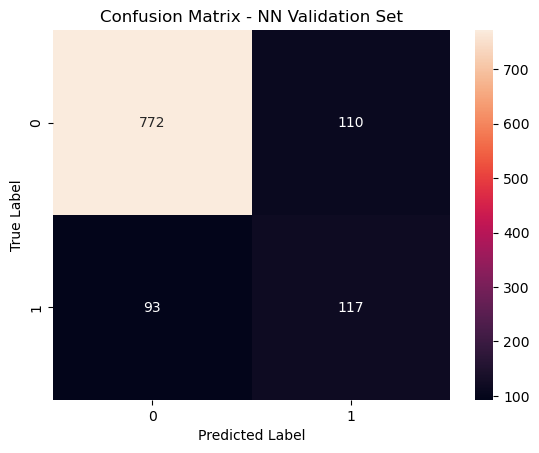

In [13]:
y_vld_hat = (nn.predict(X_vld) > 0.35).astype(int)
print("Validation Accuracy:", accuracy_score(y_vld, y_vld_hat))
print("Recall for Hit (1):", recall_score(y_vld, y_vld_hat))

sns.heatmap(
    confusion_matrix(y_vld, y_vld_hat),
    annot = True,
    fmt = 'd'
)
plt.title("Confusion Matrix - NN Validation Set")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### Accuracy and Loss Curve Analysis

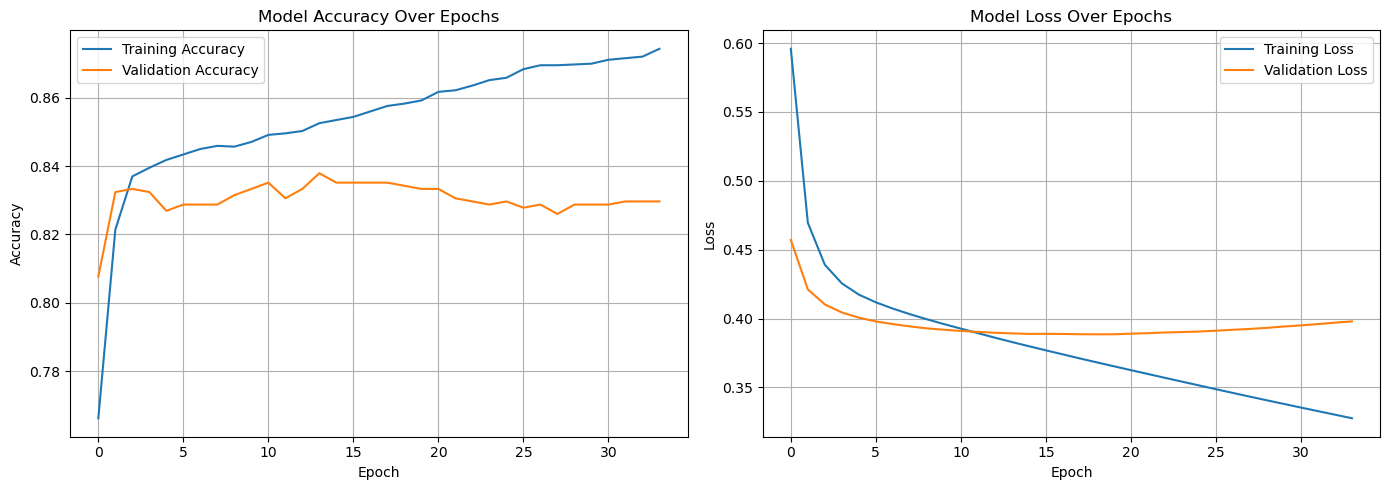

In [14]:
plt.figure(figsize = (14, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(record.history['accuracy'], label = 'Training Accuracy')
plt.plot(record.history['val_accuracy'], label = 'Validation Accuracy')
plt.title("Model Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(record.history['loss'], label = 'Training Loss')
plt.plot(record.history['val_loss'], label = 'Validation Loss')
plt.title("Model Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Testing

Test Accuracy (NN): 0.8389458272327965
Recall for Hit (1): 0.6159695817490495


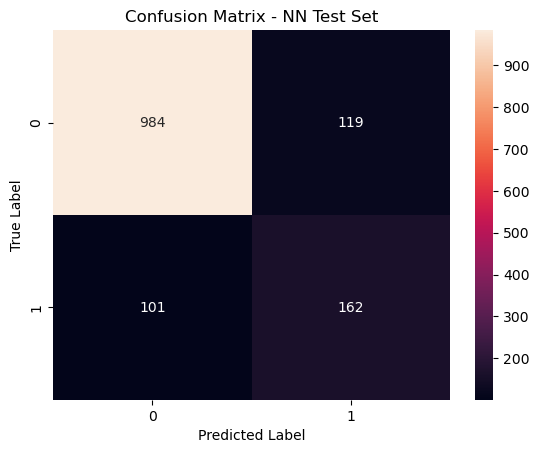

In [15]:
y_tst_hat = (nn.predict(X_tst) > 0.35).astype(int)
print("Test Accuracy (NN):", accuracy_score(y_tst, y_tst_hat))
print("Recall for Hit (1):", recall_score(y_tst, y_tst_hat))

sns.heatmap(
    confusion_matrix(y_tst, y_tst_hat),
    annot = True,
    fmt = 'd'
)
plt.title("Confusion Matrix - NN Test Set")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()